# 0. Set Up

In [1]:
# Import general modules/packages here. 
# It is a good practice to run all cells in the Notebook sequentially to avoid unexpected outputs.

import numpy as np


# force Jupyter to update loaded modules as they change 
%load_ext autoreload
%autoreload 2

# Before you continue ...
Please download and add the folder from the exercise page to the root directory of this project.      
www.rostlab.org/~bindpredict/datasets_pp1cb/disorder.zip


The folder name should be **data**. The folder contains following files: 


-- baseline_embeddings_disorder.h5     
-- disorder_seq.fasta    
-- README.md      
-- disorder_labels.fasta     
-- MSAs      
 
 
**TO DO**: add a method for automatical download.


Run the next cell to display the structure of the repo: 

In [2]:
!ls

data  lightning_logs  methods  README.md  venv	visualization  workflow.ipynb


**methods** 


-- utils    
-- nn
 Contains the actual code for pre-processing and definition of our NN. 


**visualization**     
Contains methods for ploting and the output folder with images. 



This notebook is meant to be a main driver which imports all methods and performs machine learning pipeline in abstract high-level calls. It means: we will implement the actual dataset import, network definition and training here by importing an appropriate function into the notebook. 

# Table of contents 
TO DO 

# 1. Dataset preparation

## Visualize the dataset

Reading Z-scores...done! Found 1102 proteins.
Plotting histogram of all z-scores...done! 125223 usable z-scores in total. 5.05% of all z-scores were unknown and hence removed from the histogram.
Plotting histogram of the protein lengths...done! Median length: 114.0.


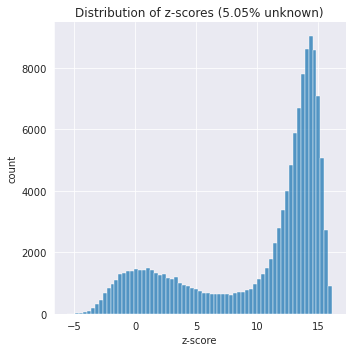

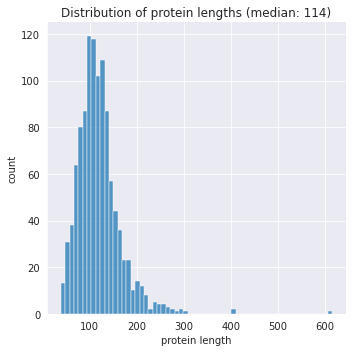

In [3]:
import visualization.visualize_dataset as vis
from methods.utils.read_embeddings import read_z_scores

z_scores = read_z_scores(z_score_file="./data/disorder_labels.fasta")
vis.plot_z_score_histogram(z_scores)
vis.plot_protein_length_histogram(z_scores)

## Embeddings
Here is an example how an embedding works. 
Each aa seq is represented as a numpy array of size (num_of_aa, 1024), where each number is a z-score. 

In [4]:
import methods.nn.disorder_dataset as dd

dataset = dd.load_dataset()

Reading embeddings...done! Found 1102 proteins.
Reading Z-scores...done! Found 1102 proteins.
Matching protein IDs...done!
131889
131889
(1024, 7)
0.0
0.0
Samples per bin [15359 20753 13106 82671]
Thresholds of bins [0.   0.25 0.5  0.75 1.  ]


In [6]:
test_index = np.random.randint(10)
test_x = dataset.x[test_index]
test_y = dataset.y[test_index]
seq_length, embedding_dim = test_x.shape
print(test_x.shape)
print(test_y.shape)
test_y.sum()/len(test_y)

(1024, 7)
()


TypeError: object of type 'numpy.float64' has no len()

## Load the dataset

In [7]:
from visualization.visualize_dataset import plot_avg_z_score_histogramm

plot_avg_z_score_histogramm(dataset.avg_y)

AttributeError: 'DisorderDataset' object has no attribute 'avg_y'

## Split the dataset to k-folds

### Sample train/test/val datasets k-times
Sampling from each of the bins ensures stratification or, in other words, that the distribution of the data is equal in every set. 


In [11]:
import torch 

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from methods.nn.disorder_dataset import collate
from methods.nn.disorder_dataset import DisorderDataset
from methods.nn.convnet import ConvNet
import pytorch_lightning as pl



def nested_cross_validation(dataset,
                            model=None,
                            mode='print_fold_info',
                            k=10, *kwargs):
    # Set fixed random number seed
    SEED = 1
    torch.manual_seed(SEED)

    # Define the K-fold Cross Validator
    skf = StratifiedKFold(n_splits=k, random_state=SEED, shuffle=True)

    # For folds results
    results = {}
    # For debugging loaders
    loaders = {}

    # Nested K-Fold Cross Validation model evaluation
    # We split the data stratified on artificially constructed bins in df['bins'
    # and extract indices.

    # By splitting we only extract indices of samples for each test/train/val sets,
    # thus we only need either X or y (equal length).
    # For stratification, however, we require the artificially assigned bins whic are also defined in the
    # dataset class

    data = dataset.y
    stratify_on = dataset.bins

    for fold, (train_val_ids, test_ids) in enumerate(skf.split(data, stratify_on)):

        print(f"Fold {fold}")

        train_ids, val_ids = train_test_split(train_val_ids,
                                              test_size=0.20,  # 0.25 x 0.8 = 0.2
                                              stratify=stratify_on[train_val_ids],
                                              random_state=SEED)

        # Define data loaders for training and testing data in this fold
        valloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=10,
            #collate_fn=collate,
            sampler=val_ids)

        trainloader = torch.utils.data.DataLoader(
            dataset,
            #collate_fn=collate,
            batch_size=10, sampler=train_ids)

        testloader = torch.utils.data.DataLoader(
            dataset,
            #collate_fn=collate,
            batch_size=10, sampler=test_ids)

        if mode == 'print_fold_info':

            loaders[fold] = [trainloader, valloader, testloader]

            print('train -  {}, avg_len - {:.2f}  |  val -  {}, avg_len - {:.2f}'.format(
                np.sum(np.bincount(stratify_on[train_ids])),
                np.sum(dataset.aa_len[train_ids]) / len(train_ids),
                np.sum(np.bincount(stratify_on[val_ids])),
                np.sum(dataset.aa_len[val_ids]) / len(val_ids)))

            print('test -  {}, avg_len - {:.2f}'.format(
                np.sum(np.bincount(stratify_on[test_ids])),
                np.sum(dataset.aa_len[test_ids]) / len(test_ids)))

            show_batches = 5
            for i, batch in enumerate(trainloader):
                print(f"Batch {i}:\n{batch}\n")
                if i == show_batches:
                    break

            print()

        elif mode == 'evaluate':
            trainer = pl.Trainer(weights_summary=None, max_epochs=100, deterministic=True)
            trainer.fit(model, train_dataloader=trainloader, val_dataloaders=valloader)
        else:
            print("Mode is not specified!")
            break

    if mode == 'evaluate':
        return results
    else:
        return loaders

In [12]:
hparams = {'hidden_size': 112,
               "learning_rate": 1e-4
               }
nested_cross_validation(dataset, mode='evaluate', model=ConvNet(hparams=hparams))
#

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.


Sequential(
  (0): Conv1d(1024, 64, kernel_size=(4,), stride=(1,))
  (1): PReLU(num_parameters=1)
  (2): Conv1d(64, 16, kernel_size=(2,), stride=(1,))
  (3): PReLU(num_parameters=1)
  (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=96, out_features=1, bias=True)
)
Fold 0


/home/matthias/.conda/envs/pp1/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/home/matthias/.conda/envs/pp1/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x16 and 96x1)

# 2. Create a model
TO DO

# 3. Train a model
TO DO

# 4. Visualize results